In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, irfft
import scipy.signal as sig
from scipy.io import wavfile
from scipy.stats import ttest_ind
from playsound import playsound
%matplotlib inline

## Cleaning

In [2]:
def gather_data(samplerate,data):
    N = data.shape[0]
    length = N / samplerate
    T0 = length
    dt = T0/N
    time = np.linspace(0., length, data.shape[0])

    return N, length, T0, dt, time   

def cleaning(samplerate,data,freqCutoff):
    
    N, length, T0, dt, time = gather_data(samplerate, data)

    Vdusty = (2/N)*fft(data[:, 1])
    freq = fftfreq(N,dt)
    
    VCleanf = Vdusty.copy()

    for i in range(len(freq)):
        if abs(freq[i]) > freqCutoff:
            VCleanf[i] = 0       

    VClean = ifft(N*VCleanf)
    VC = np.real(VClean)
    return time,VClean,freq

In [3]:
ps_sr, ps_dat = wavfile.read('./peace-sells-intro.wav')

hw_sr, hw_dat = wavfile.read('./holy-wars-intro.wav')

cat_sr, cat_dat = wavfile.read('./greatest-song-ever-intro.wav')

C:\Users\elias\AppData\Local\Temp\ipykernel_10284\3418896276.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  ps_sr, ps_dat = wavfile.read('./peace-sells-intro.wav')
C:\Users\elias\AppData\Local\Temp\ipykernel_10284\3418896276.py:3: WavFileWarning: Reached EOF prematurely; finished at 16772276 bytes, expected 16772284 bytes from header.
  hw_sr, hw_dat = wavfile.read('./holy-wars-intro.wav')


In [53]:
ps_N, ps_length, ps_T0, ps_dt, ps_time = gather_data(ps_sr, ps_dat)

hw_N, hw_length, ps_T0, hw_dt, hw_time = gather_data(hw_sr, hw_dat)

cat_N, cat_length, cat_T0, cat_dt, cat_time = gather_data(hw_sr, hw_dat)

ps_cutoff = 50000

hw_cutoff = 1600

cat_cutoff = 1600

ps_time, ps_intro, ps_freq = cleaning(ps_sr, ps_dat, ps_cutoff)

hw_time, hw_intro, hw_freq = cleaning(hw_sr, hw_dat, hw_cutoff)

cat_time, cat_intro, cat_freq = cleaning(cat_sr, cat_dat, cat_cutoff)

In [54]:
ps_cleaned_fft = (2/ps_N)*fft(ps_intro)

hw_cleaned_fft = (2/hw_N)*fft(hw_intro)

cat_cleaned_fft = (2/cat_N)*fft(cat_intro)


When recreating the cleaned ffts, we saw it best to begin by first normalizing the amplitudes of each song as the scale of the amplitudes of these fourier transforms is entirely the result of how the files were handled as they were downloaded and converted into .wav files, and does not say anything about the integral volume difference of the songs. 

It was decided to ignore the voltage drop term in the ffts as it needlesly skewed some of our power series to the point where they no longer presented useful information.

In [55]:
ps_norm_fft = ps_cleaned_fft[1:]/np.max(ps_cleaned_fft[1:])

hw_norm_fft = hw_cleaned_fft[1:]/np.max(hw_cleaned_fft[1:])

cat_norm_fft = cat_cleaned_fft[1:]/np.max(cat_cleaned_fft[1:])

# changing the size of the arrays presents the need to redefine our lengths for our arrays
ps_N = len(ps_norm_fft)
hw_N = len(hw_norm_fft)
cat_N = len(cat_norm_fft)

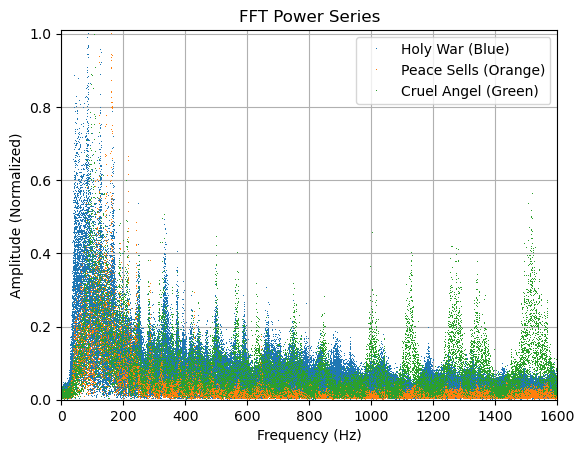

In [56]:
# due to a very strange error in the cleaning function, we must make sure to redefine our 
# cat_N variable based on the actual length of the cat_freq array
cat_N = len(cat_freq)

plt.plot(hw_freq[0:hw_N//2], np.abs(hw_norm_fft[0:hw_N//2]), marker = ",", linestyle="", label = "Holy War (Blue)")
plt.plot(ps_freq[0:ps_N//2], np.abs(ps_norm_fft[0:ps_N//2]), marker = ",", linestyle="", label = "Peace Sells (Orange)")
plt.plot(ps_freq[0:cat_N//2], np.abs(cat_norm_fft[0:cat_N//2]), marker = ",", linestyle="", label = "Cruel Angel (Green)")

plt.title("FFT Power Series")
plt.ylabel("Amplitude (Normalized)")
plt.xlabel("Frequency (Hz)")
plt.axis([0,1600,0,1.01])
plt.grid()
plt.legend()

In the figure above, we see the plots of the power series for each of the 3 songs we are analyzing with the frequency in the x-axis and normalized amplitude in the y-axis. One particularly interesting freature to note about this plot is that 

Below, we find the differences between the amplitudes of the power series of the songs in our investigation for each frequency. Since we are only performing simple pairwise analysis, we found it best to simply take the normalized difference between the two songs in our analysis and then characterize the differences between the power series by plotting our findings.

Unfortunately, this process is not as straight forward as simply subtracting the two power series with one another. Since each of the power series we generated from our fourier transoformations of our songs are each binned in frequency bins of different sizes, a simple array operation is not possible. To actually perform this operation, we must perform a rebinning operation on one of the arrays such that the two arrays are of the same length and binsize. As such we must employ the use of the below *rebin_diff* function to take in the data of two different power series, then output the rebinned differences between the two series.

In [57]:
def rebin_diff(fft_1, fft_2, freq_1, freq_2):
    """
    Takes in 2 fft's and their respective frequencies, then outputs a rebinned
    array containing their sums and differences.
    
    args:
    
        fft_1 - signal array from an fft transofrmation. Should be the shorter
                of the two arrays
        fft_2 - similar to fft_1. Is the longer of the two signals
        
        freq_1 - frequency array associated with fft_1
        
        freq_2 - frequency array associated with fft_2
    
    returns:
        
        amp_diff - differences of the values contained in the two input fft's.
                   Array is same size as fft_1 array.
        
    """
    
    # initializing arrays
    amp_diff = np.zeros(len(freq_1))
    
    # assigning fft_1 values to array as initial values
    amp_diff = amp_diff + fft_1
    
    # for tracking index of fft_1, amp_diff and amp_sum arrays
    j = 0
    
    # loops through each index of the longer array
    for i in range(len(freq_2)):
    
        # checks to see if indexing is to close to upper bound
        # of fft_1 array
        if j < len(freq_1)-2:
            
            # if freq_2 bin is greater than current right bound
            # of freq_1 bin, increment j
            if freq_1[j+1] <= freq_2[i]:
                j += 1 
            
            # finding difference between freq_1 cells
            dist = freq_1[j+1] - freq_1[j]
            
            # finds absolute distance between freq_2 cell and freq_1 cell
            f_dist = np.abs(freq_2[i] - freq_1[j])
            norm_f_dist = f_dist/dist
            
            if norm_f_dist > 1:
                print(i,j)
                
            # adds data to amp_diff array
            amp_diff[j] -= fft_2[i]*(1-norm_f_dist)
            amp_diff[j+1] -= fft_2[i]*norm_f_dist

        else:
            # just tacks on remaining fft_2 to end of output arrays
            # not exacltly super accurate, but doesn't cause
            # significant problems
            amp_diff[j] -= fft_2[i]
            
    return freq_1, amp_diff


It should also be noted that we opted to only look at the positive frequencies when finding these differences as incuding the negative frequencies resulted in errors occuring in our rebin function, and while we would loose a little bit of phase data in our resulting plots, we believe that we still ended up with more than more than enough information to support our claims. 

In [58]:
# generating arrays of the differences between the song power series using rebin function

ps_v_hw_freq, ps_v_hw_diff = rebin_diff(ps_norm_fft[0:ps_N//2], 
                                        hw_norm_fft[0:hw_N//2], 
                                        ps_freq[0:ps_N//2], 
                                        hw_freq[0:hw_N//2])

cat_v_ps_freq, cat_v_ps_diff = rebin_diff(ps_norm_fft[0:ps_N//2], 
                                          cat_norm_fft[0:cat_N//2], 
                                          ps_freq[0:ps_N//2], 
                                          cat_freq[0:cat_N//2])

hw_v_cat_freq, hw_v_cat_diff = rebin_diff(cat_norm_fft[0:cat_N//2], 
                                          hw_norm_fft[0:hw_N//2], 
                                          cat_freq[0:cat_N//2], 
                                          hw_freq[0:hw_N//2])

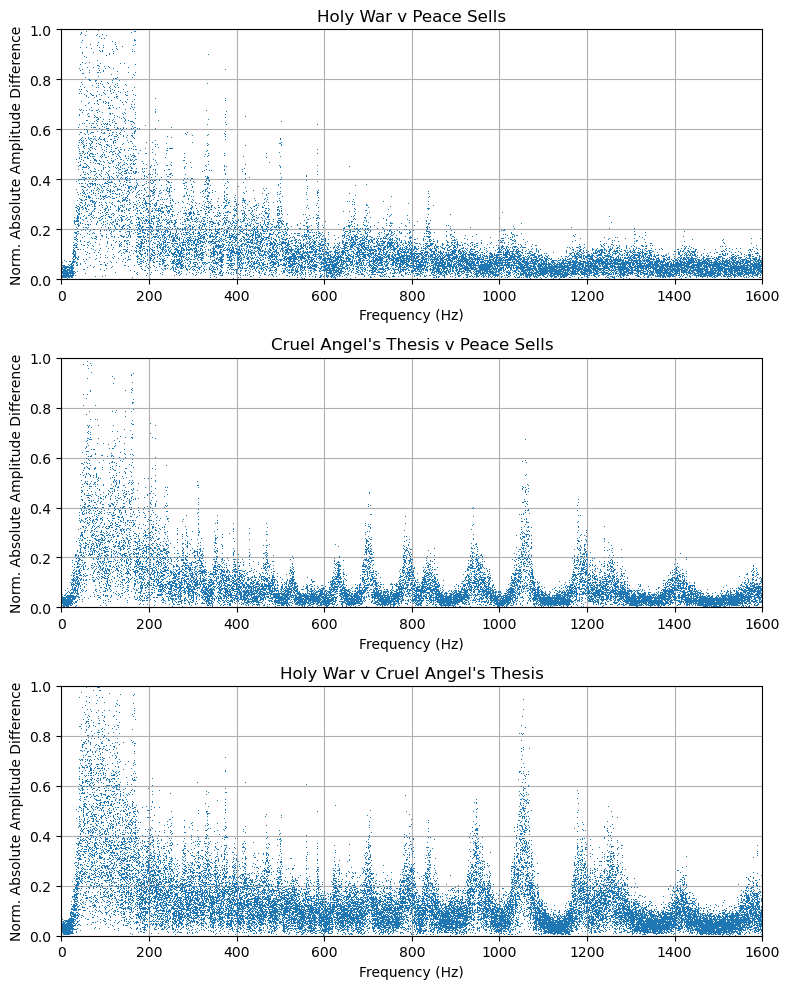

In [61]:
# plotting our results

fig, ax = plt.subplots(3,1, figsize = (8,10))

# Holy War v Peace Sells
ax[0].plot(ps_v_hw_freq, np.abs(ps_v_hw_diff), marker = ",", linestyle="")
ax[0].axis([0,1600,0,1])
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Norm. Absolute Amplitude Difference")
ax[0].set_title("Holy War v Peace Sells")
ax[0].grid()

# Cruel Angel's Thesis v Peace Sells
ax[1].plot(cat_v_ps_freq, np.abs(cat_v_ps_diff), marker = ",", linestyle="")
ax[1].axis([0,1600,0,1])
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Norm. Absolute Amplitude Difference")
ax[1].set_title("Cruel Angel's Thesis v Peace Sells")
ax[1].grid()

# Holy War v Cruel Angel's Thesis
ax[2].plot(hw_v_cat_freq, np.abs(hw_v_cat_diff), marker = ",", linestyle="")
ax[2].axis([0,1600,0,1])
ax[2].set_xlabel("Frequency (Hz)")
ax[2].set_ylabel("Norm. Absolute Amplitude Difference")
ax[2].set_title("Holy War v Cruel Angel's Thesis")
ax[2].grid()

plt.tight_layout()


Above we see the resulting plots of our power series comparisons. In the y-axis, we have the absolute difference in amplitudes between the two songs being compared, and in the x-axis we have the frequency from 0 to about 1600 Hz (as that's where the cutoff is for most of our cleaned signals).

Amongst all of the plots, we see a same general trend of having large variations in the lower frequencies that begin to drop off into lower differences as we increase the frequency. However, within this region of lower variation we begin to see some interesting distinctions between the three plots. In the two plots making comparisons between the Megadeath songs and A Cruel Angel's Thesis, we notice distinct spikes at very specific higher frequencies that are not present in the comparison between the two Megadeath songs. 

These results seem to support the idea that the two Megadeath songs are, in fact, more similar to one another than to a song that is completely out of genre. While this could be used to support the notion that the two songs are similar to one another, it should be noted that there are still very significant differences between the two songs in the lower frequency range that still seem to suggest a dissimilarity between the two songs, although given the fact that this feature is also present in the comparison to Cruel Angel's Thesis, once could also make the argument that this feature could simply be due to some form of noise that exists in the lower frequencies that is not actually present within the song at all.

While the power series analysis of these songs did in fact show some distinct differences between different Megadeath songs, more investigation is required, likely on a larger sample size of songs (perhaps including more out of genre songs as well as more songs within the same genre, but from different bands) to fully characterize both the validity of the differences we found as well as by how much the two songs vary from one another.